In [292]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import statsmodels.api as sm
import scipy.stats as stats

In [293]:
sns.set_theme()

In [294]:
IMAGES_PATH = Path("../images/")
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Prepare the data

In [295]:
strats = [ 'target_1d', 'dummy_clf', 'log_clf', 'svm_clf', 'rnd_clf', 'mlp_clf', 'vot_clf', 'ada_clf', 'grb_clf']

In [296]:
ticker = 'portfolio'

In [297]:
with pd.HDFStore('../data/data.h5') as store:
    rets = store[f'models/test_result/{ticker}'][strats]

In [298]:
returns = {}
for strat in strats:
    x = rets.groupby("Date")[strat].sum()
    returns.update({x.name: x})

In [299]:
portfolio_rets = pd.DataFrame(returns)
portfolio_rets.rename(columns = {'target_1d': 'passive'}, inplace = True)
#portfolio_rets.head()

In [300]:
market_index = pd.read_hdf('../data/assets.h5', 'yfinance/prices/test/vti')

In [301]:
market_rets = np.log(market_index['Adj Close']/market_index['Adj Close'].shift(1)).dropna()
market_rets = market_rets.loc[portfolio_rets.index]
market_rets.name = 'vti'
market_rets = pd.DataFrame(market_rets)

# Examining distribution

In [302]:
#portfolio_rets.describe()

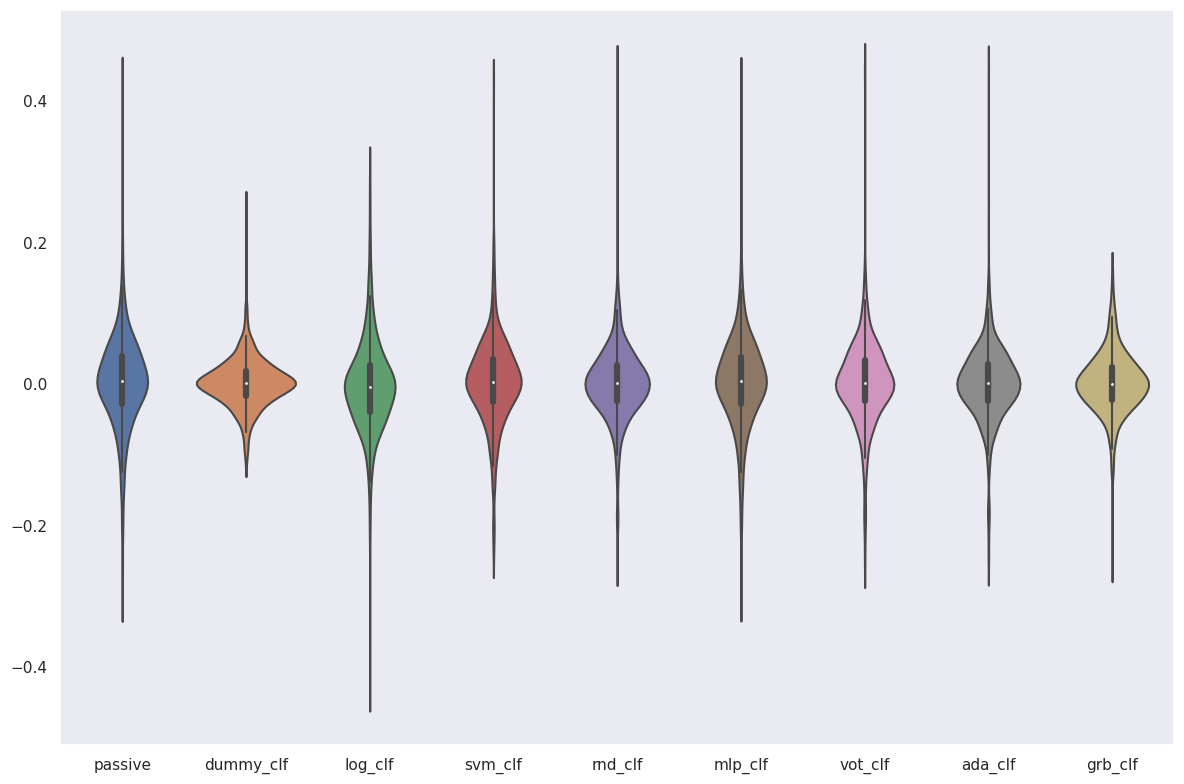

In [303]:
fig,ax = plt.subplots(figsize=(12,8))
d = sns.violinplot(portfolio_rets, ax = ax)
d.grid(False)
save_fig(f"distribution_returns_{ticker}")

# Bootstrapping

In [304]:
from sklearn.utils import resample

In [320]:
def boostrap(x, b=20000, alpha = 0.05, plot=False):
    n = len(x)
    mu = x.mean()
    se_mean = x.std()/np.sqrt(n)
    qt = stats.t.ppf(q= 1-alpha, df=n-1)
    
    #generate bootstrap distribution of sample mean
    mean_samples = []
    for i in range(0,b):
        mean_samples.append(resample(x, replace=True, n_samples=30).mean())
        
    mean_samples = np.array(mean_samples)
    #standard error and sample quantiles
    se_mean_boot = mean_samples.mean()
    quantile_boot = np.percentile(mean_samples,95)
    
    #Results
    print("\nBootstrap results:")
    #print("Standard error:", se_mean_boot)
    #print("t-type CI:",mu + np.array([qt])*se_mean_boot)
    print("Percentile CI:", quantile_boot)
    
    if plot:
        g=sns.displot(mean_samples, kde=True)
        g.figure.set_size_inches(10, 4)
        plt.axvline(x=np.percentile(mean_samples, 95), color ='r')
        save_fig(f"null_model_dist{ticker}")
        
    return mean_samples


In [321]:
def draw_qqplot(x):
    
    n = 10000
    z = (x - np.mean(x))/np.std(x)
    
    stats.probplot(z, dist="norm", plot=plt)
    save_fig(f"normality_sampling_dist{ticker}")
    plt.show()

## case 1: Best ML model vs random walk null model on passive strategy

In [322]:
null_model = portfolio_rets['passive'] - portfolio_rets['dummy_clf']

In [323]:
alt_model = portfolio_rets['passive'] - portfolio_rets['svm_clf']


Bootstrap results:
Percentile CI: 0.022553407037014573


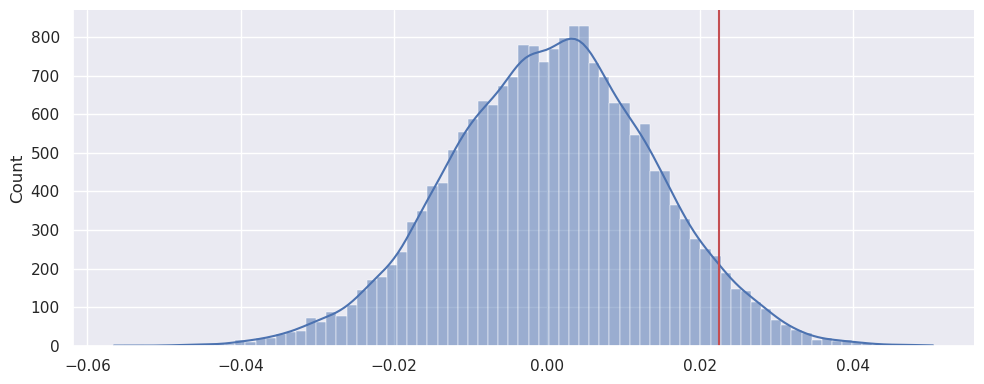

In [324]:
sample_dist = boostrap(null_model, plot = True)

### Normality of sampling distribution

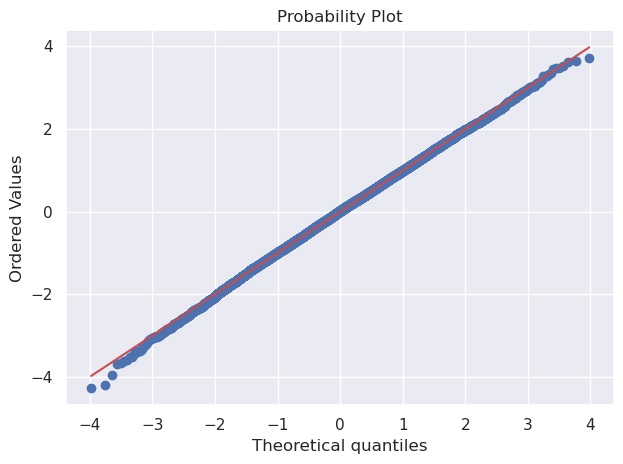

In [325]:
draw_qqplot(sample_dist)

## Hypothesis test

**Null hypothesis:** mean of excess return on SVC is less than 0.02 <br>
**Alt hypothesis:** mean of excess return on SVC is greater than 0.02

## Calculation of p-values

Sampling distribution is not normal and clearly not independent. We need monte carlo simulations here.

In [327]:
def boot_matrix(z, B):
    """Bootstrap sample
    
    Returns all bootstrap samples in a matrix"""
    
    n = len(z)  # sample size
    idz = np.random.randint(0, n, size=(B, n))  # indices to pick for all boostrap samples
    return z[idz]

In [328]:
def bootstrap_t_pvalue(x, y, equal_var=False, B=10000, plot=False):
    """Bootstrap p values for two-sample t test
    
    Returns boostrap p value, test statistics and parametric p value"""
    
    # Original t test statistic
    orig = stats.ttest_ind(x, y, equal_var=equal_var)
    
    # Generate boostrap distribution of t statistic
    xboot = boot_matrix(x - x.mean(), B=B) # important centering step to get sampling distribution under the null
    yboot = boot_matrix(y - y.mean(), B=B)
    sampling_distribution = stats.ttest_ind(xboot, yboot, axis=1, equal_var=equal_var)[0]

    # Calculate proportion of bootstrap samples with at least as strong evidence against null    
    p = np.mean(sampling_distribution >= orig[0])
    
    # RESULTS
    print("p value for null hypothesis of equal population means:")
    print("Parametric:", orig[1])
    print("Bootstrap:", 2*min(p, 1-p))
    
    # Plot bootstrap distribution
    if plot:
        plt.figure()
        plt.hist(sampling_distribution, bins="fd") 

In [329]:
np.random.seed(42)
bootstrap_t_pvalue(null_model.values, alt_model.values)

p value for null hypothesis of equal population means:
Parametric: 0.7592946403304903
Bootstrap: 0.7672


## Case 2: ML model vs random walk null model on passive strategy

In [330]:
null_model = market_rets.values - portfolio_rets['dummy_clf'].values
alt_model = market_rets.values - portfolio_rets['svm_clf'].values

In [331]:
null = market_rets.values.reshape((len(market_rets))) - portfolio_rets['dummy_clf'].values.reshape((len(portfolio_rets)))

In [332]:
alt = market_rets.values.reshape((len(market_rets))) - portfolio_rets['svm_clf'].values.reshape((len(portfolio_rets)))


Bootstrap results:
Percentile CI: 0.00910983063355769


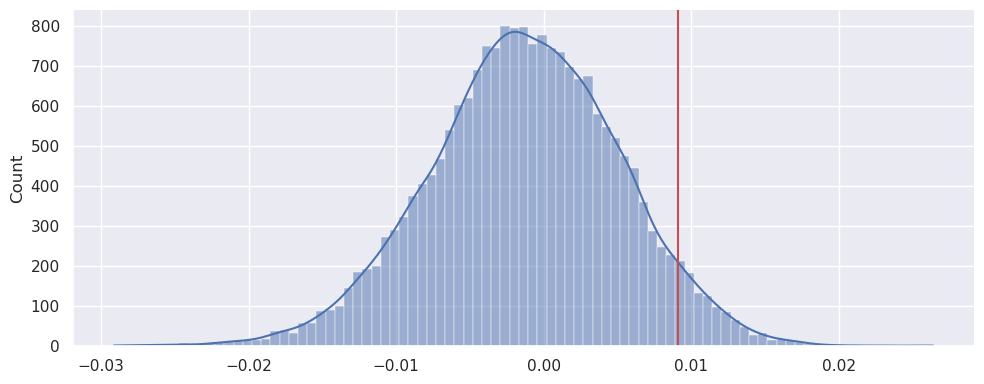

In [333]:
sample_dist = boostrap(null, plot = True)

In [334]:
np.random.seed(42)
bootstrap_t_pvalue(null, alt)

p value for null hypothesis of equal population means:
Parametric: 0.7376516660142886
Bootstrap: 0.746


**we cannot reject null hypothesis**